In [1]:
# ! pip install xarray dask stackstac planetary-computer rioxarray matplotlib

In [2]:

import math
import stackstac # type: ignore
import planetary_computer # type: ignore
import matplotlib.pyplot as plt
import numpy as np
from dask.diagnostics import ProgressBar # type: ignore
from dask.array import nanmedian # type: ignore

from pystac_client import Client # type: ignore

from dask.distributed import Client as DaskClient # type: ignore

client = DaskClient()  # Start Dask client with default settings
client

<Client: 'tcp://127.0.0.1:51923' processes=4 threads=12, memory=32.00 GiB>

In [3]:
# Access the Planetary Computer's STAC API
stac_api_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
client = Client.open(stac_api_url)

# Search for Sentinel-2 imagery
search = client.search(
    collections=["sentinel-2-l2a"],
    bbox=[-106.5, 35.0, -106.4, 35.1],  # Define a bounding box (e.g., around a location)
    datetime="2023-01-01/2023-12-31",  # Specify time range for NDVI time series
    query={"eo:cloud_cover": {"lt": 20}},  # Filter by cloud cover
)

# Get the items from the search
items = search.item_collection()

# Sign the items for authenticated access
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

# Stackstac to read the imagery into an xarray DataArray
stack = stackstac.stack(
    signed_items,
    assets=["B04", "B08"],  # Red and NIR bands for NDVI
    resolution=30,
    dtype=np.float64,
    bounds_latlon=(-106.5, 35.0, -106.4, 35.1), # for some strange reason takes longer if this is excluded
    #epsg=4326,
    rescale=False  
)

# Use labeled dimensions
stack = stack.rename(band="band", x="longitude", y="latitude", time="time")
stack 


<xarray.DataArray 'stackstac-2569571b33925e549012d810e2752111' (time: 96,
                                                                band: 2,
                                                                latitude: 375,
                                                                longitude: 311)> Size: 179MB
dask.array<fetch_raster_window, shape=(96, 2, 375, 311), dtype=float64, chunksize=(1, 1, 375, 311), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 768B 2023-...
    id                                       (time) <U54 21kB 'S2B_MSIL2A_202...
  * band                                     (band) <U3 24B 'B04' 'B08'
  * longitude                                (longitude) float64 2kB 3.631e+0...
  * latitude                                 (latitude) float64 3kB 3.885e+06...
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    ...                                       ...
    proj:shape                               object 8B {10980}
    gsd                                      float64 8B 10.0
    common_name                              (band) <U3 24B 'red' 'nir'
    center_wavelength                        (band) float64 16B 0.665 0.842
    full_width_half_max                      (band) float64 16B 0.038 0.145
    epsg                                     int64 8B 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(363090, 3873930, 372420, 3885...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 363090.00|\n| 0.00,-30.00, 3885180.00|\n| 0.0...
    resolution:  30

In [4]:
# Group data by month and calculate the median for each month
# Convert time to "month" granularity
stack = stack.resample(time="1ME").reduce(nanmedian)
stack

<xarray.DataArray 'stackstac-2569571b33925e549012d810e2752111' (time: 12,
                                                                band: 2,
                                                                latitude: 375,
                                                                longitude: 311)> Size: 22MB
dask.array<stack, shape=(12, 2, 375, 311), dtype=float64, chunksize=(1, 2, 375, 311), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * band                                     (band) <U3 24B 'B04' 'B08'
  * longitude                                (longitude) float64 2kB 3.631e+0...
  * latitude                                 (latitude) float64 3kB 3.885e+06...
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    proj:epsg                                int64 8B 32613
    constellation                            <U10 40B 'Sentinel 2'
    ...                                       ...
    gsd                                      float64 8B 10.0
    common_name                              (band) <U3 24B 'red' 'nir'
    center_wavelength                        (band) float64 16B 0.665 0.842
    full_width_half_max                      (band) float64 16B 0.038 0.145
    epsg                                     int64 8B 32613
  * time                                     (time) datetime64[ns] 96B 2023-0...
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(363090, 3873930, 372420, 3885...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 363090.00|\n| 0.00,-30.00, 3885180.00|\n| 0.0...
    resolution:  30

In [5]:
# Select the NIR (B08) and Red (B04) bands
nir = stack.sel(band="B08")
red = stack.sel(band="B04")

# NDVI Calculation
ndvi = (nir - red) / (nir + red)

# Enable Dask to use multiple cores for computation
ndvi = ndvi.chunk({"time": 1, "latitude": 100, "longitude": 100})

# Compute NDVI across the time series using Dask's parallelism
with ProgressBar():
    ndvi = ndvi.compute()    

In [6]:
ndvi

<xarray.DataArray 'stackstac-2569571b33925e549012d810e2752111' (time: 12,
                                                                latitude: 375,
                                                                longitude: 311)> Size: 11MB
array([[[0.07386716, 0.38556567, 0.19905262, ..., 0.2660894 ,
         0.25496768, 0.27411227],
        [0.06923783, 0.0881459 , 0.17942459, ..., 0.27044776,
         0.27518869, 0.29214015],
        [0.06541059, 0.07892026, 0.12976799, ..., 0.27081113,
         0.22993133, 0.27507781],
        ...,
        [0.07030636, 0.06135987, 0.05299276, ..., 0.1804632 ,
         0.17958826, 0.17682403],
        [0.06557048, 0.05608283, 0.05414452, ..., 0.2096964 ,
         0.17473118, 0.20545301],
        [0.09304768, 0.05426019, 0.04710425, ..., 0.19162351,
         0.17286432, 0.18753044]],

       [[0.07743097, 0.38776807, 0.23583181, ..., 0.2578125 ,
         0.26690759, 0.27077614],
        [0.09876954, 0.08494208, 0.19127174, ..., 0.27393075,
         0.29423975, 0.3001297 ],
        [0.06140652, 0.10094637, 0.09988692, ..., 0.27281999,
         0.23610403, 0.28658537],
...
        [0.0587314 , 0.04413619, 0.03834356, ..., 0.15611448,
         0.16687684, 0.16888046],
        [0.05454545, 0.04370629, 0.04103165, ..., 0.1981982 ,
         0.16609881, 0.20248791],
        [0.06712863, 0.03091873, 0.04130943, ..., 0.17621338,
         0.16392673, 0.18577445]],

       [[0.20129171, 0.42200957, 0.18472395, ..., 0.22171301,
         0.23792487, 0.2483263 ],
        [0.08653316, 0.11700552, 0.1436114 , ..., 0.26487439,
         0.26917093, 0.28293145],
        [0.06206897, 0.11249168, 0.15114628, ..., 0.25827119,
         0.23221133, 0.25293202],
        ...,
        [0.05127153, 0.04026258, 0.03413855, ..., 0.17412032,
         0.19313019, 0.17910286],
        [0.05116079, 0.03839963, 0.03187086, ..., 0.22628078,
         0.19866815, 0.22301803],
        [0.06485741, 0.03421355, 0.03059313, ..., 0.19605646,
         0.18342287, 0.20014565]]])
Coordinates: (12/16)
  * longitude                                (longitude) float64 2kB 3.631e+0...
  * latitude                                 (latitude) float64 3kB 3.885e+06...
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    proj:epsg                                int64 8B 32613
    constellation                            <U10 40B 'Sentinel 2'
    sat:orbit_state                          <U10 40B 'descending'
    ...                                       ...
    proj:transform                           object 8B {0.0, 3900000.0, 30000...
    proj:bbox                                object 8B {300000.0, 3790200.0, ...
    proj:shape                               object 8B {10980}
    gsd                                      float64 8B 10.0
    epsg                                     int64 8B 32613
  * time                                     (time) datetime64[ns] 96B 2023-0...

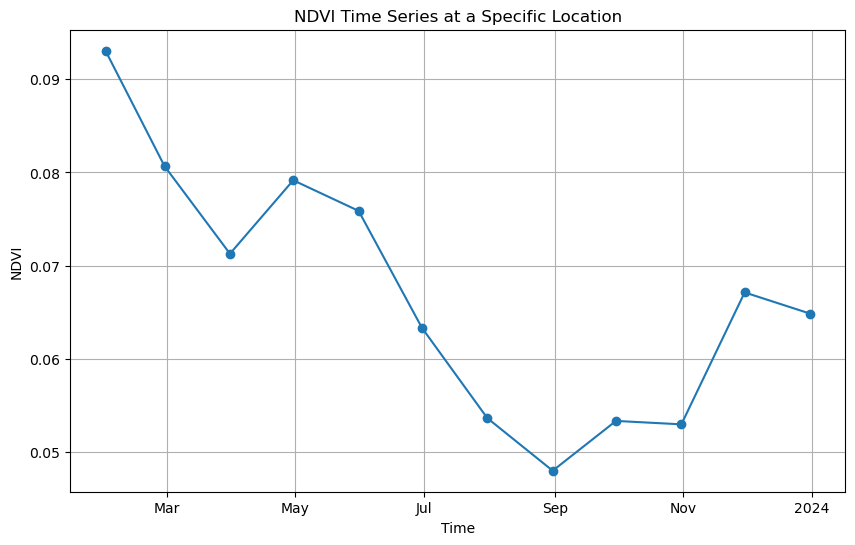

In [7]:
# Pick a specific point (latitude, longitude)
lat_point, lon_point = 35.05, -106.45

# Extract the NDVI values at the specific point over time
ndvi_timeseries = ndvi.sel(latitude=lat_point, longitude=lon_point, method="nearest")

# Plot the time series
plt.figure(figsize=(10, 6))
ndvi_timeseries.plot.line(marker="o")
plt.title("NDVI Time Series at a Specific Location")
plt.ylabel("NDVI")
plt.xlabel("Time")
plt.grid()
plt.show()


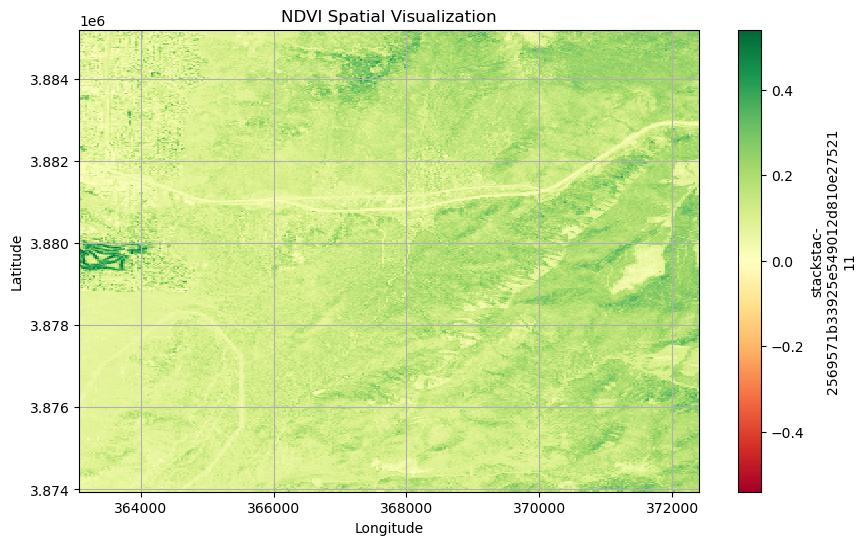

In [8]:
# Select a specific time (e.g., the first time step)
ndvi_single_time = ndvi.isel(time=0)

# Plot NDVI spatially for this time step
plt.figure(figsize=(10, 6))
ndvi_single_time.plot(cmap="RdYlGn")
plt.title("NDVI Spatial Visualization")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()


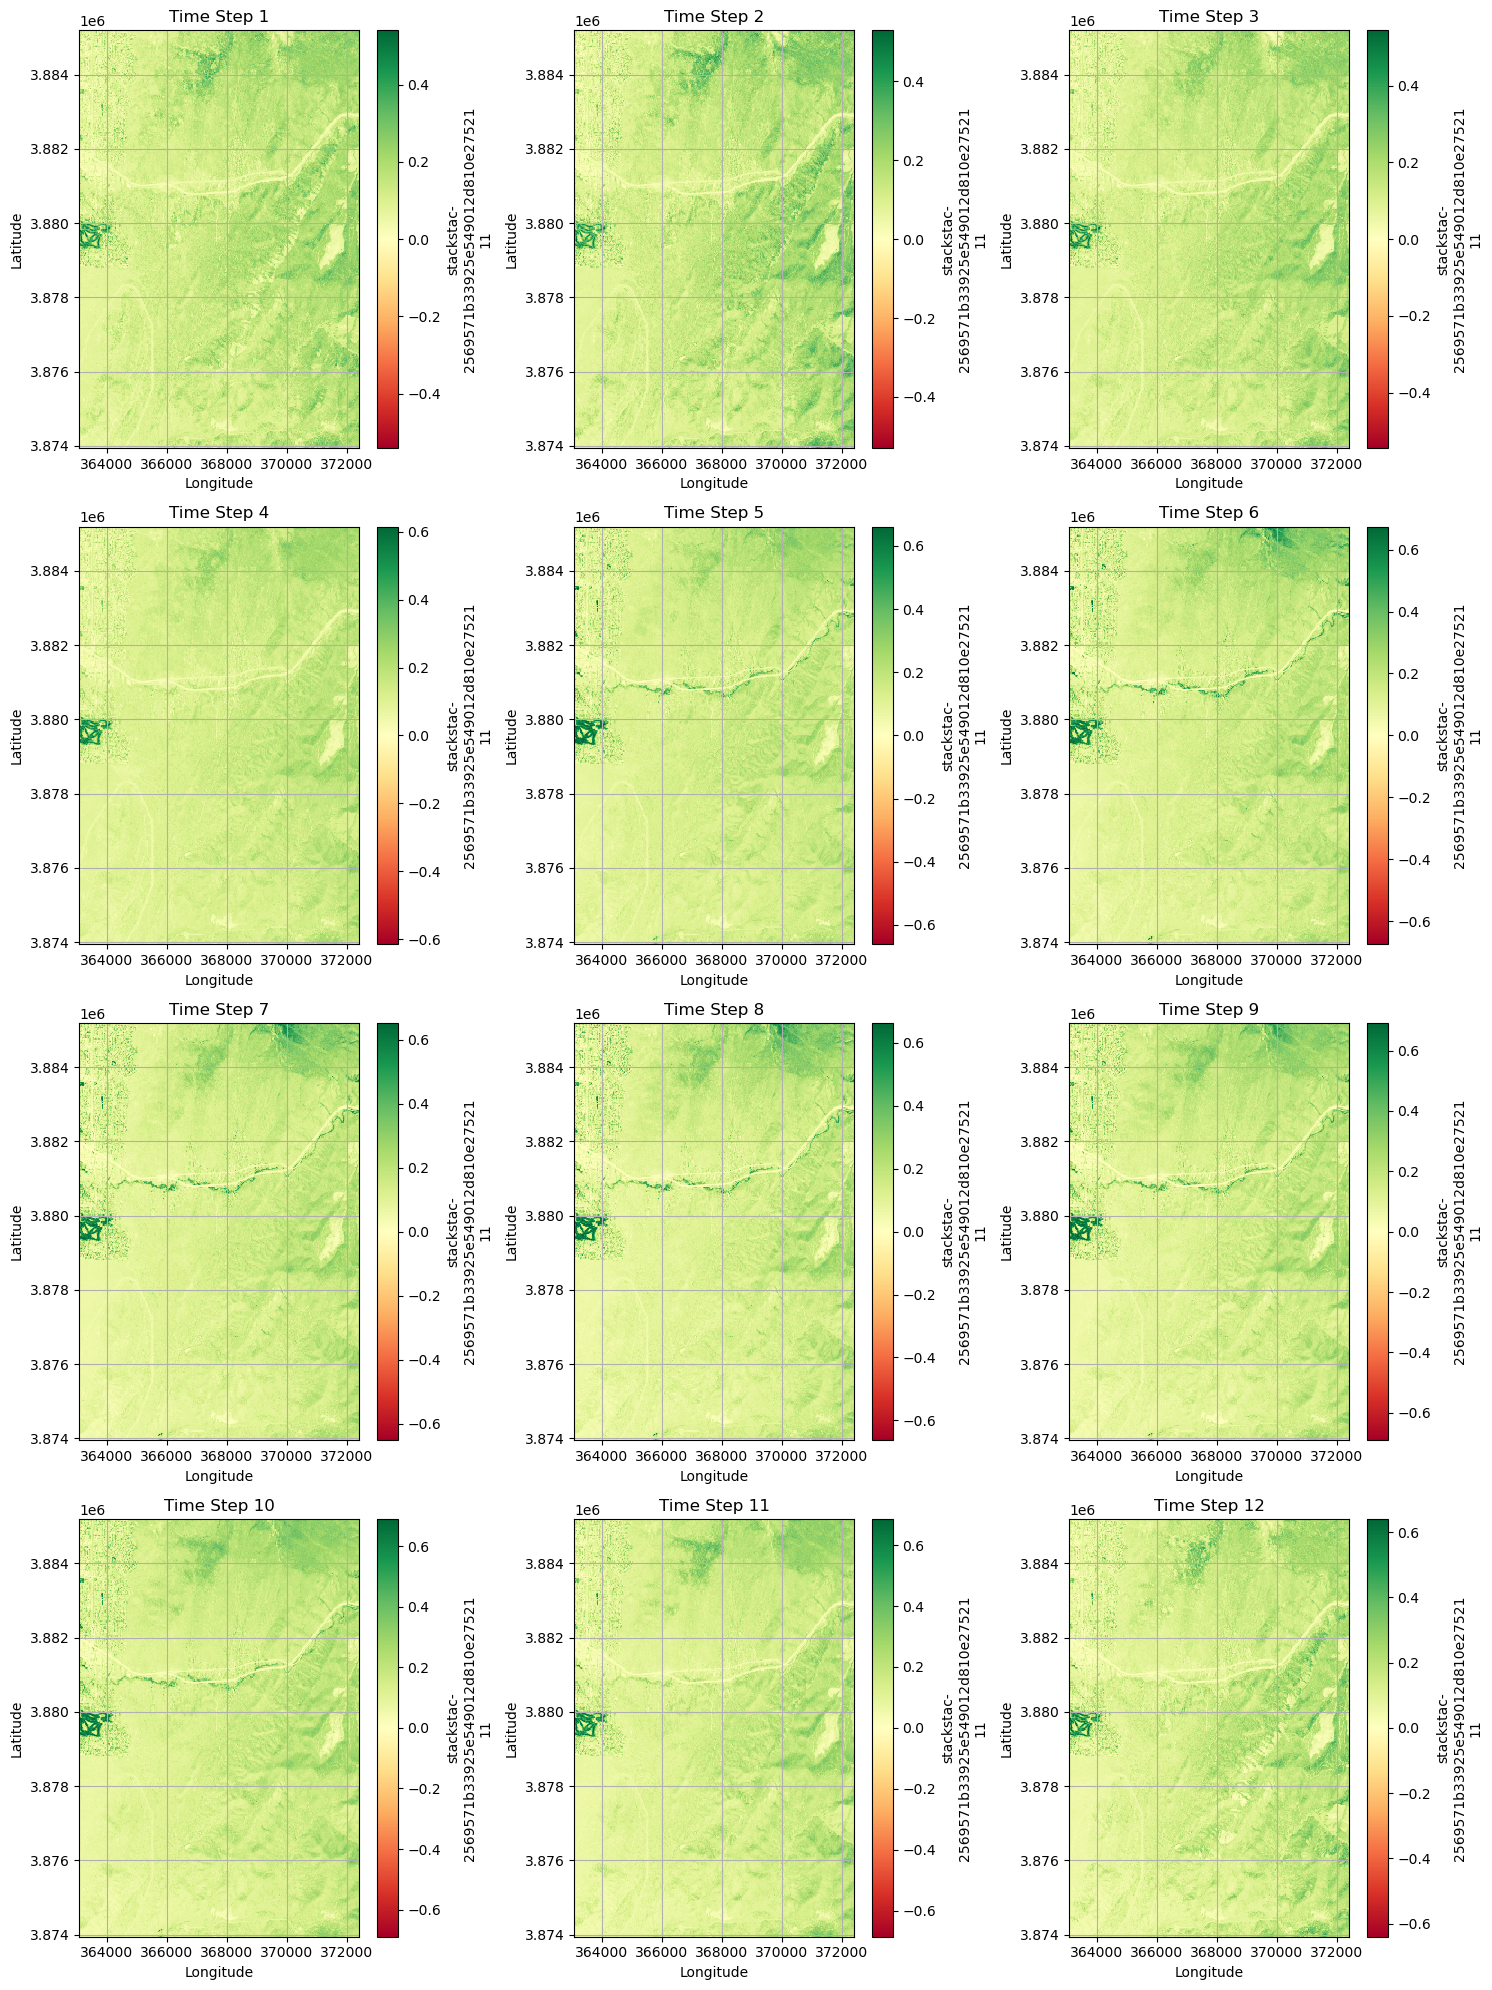

In [9]:
# Get the number of time steps
n_time_steps = ndvi.sizes['time']

# Define the number of rows and columns for the subplots (adjust based on your preference)
n_cols = 3  # Number of columns
n_rows = math.ceil(n_time_steps / n_cols)  # Calculate number of rows based on total time steps

# Create a figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flatten the axes array for easy iteration (if needed for multiple rows)
axes = axes.ravel()

# Loop through each time step and plot in the respective subplot
for i in range(n_time_steps):
    # Select the NDVI for the i-th time step
    ndvi_single_time = ndvi.isel(time=i)
    
    # Plot NDVI for the current time step on the appropriate subplot axis
    ndvi_single_time.plot(ax=axes[i], cmap="RdYlGn")
    
    # Set the title for each subplot
    axes[i].set_title(f"Time Step {i+1}")
    axes[i].set_xlabel("Longitude")
    axes[i].set_ylabel("Latitude")
    axes[i].grid()

# Hide any unused subplots if the number of time steps isn't a perfect multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the figure with all time steps plotted
plt.show()
